In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import random
import lib

In [2]:
X_val, y_val, X_test, y_test = lib.load_dataset("../dataset", rgb=False)

In [3]:
X_val_bgr = X_val

In [4]:
def show_image(img, to_rgb=True):
    if to_rgb:
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        rgb = img
    plt.imshow(rgb,interpolation='nearest')
    plt.show()

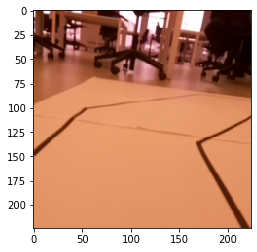

In [5]:
show_image(X_val_bgr[200])

In [6]:
class Config:
    def __init__(self, *args, **kwargs):
        self._d = kwargs
    def __getattr__(self, name):
        return self._d[name]

In [7]:
config = Config(
    gaussian_blur_kernel_size=(3, 3),
    gaussian_blur_sigma_x=1,
    top_offset_pct=0.3,
    canny_threshold1=100,
    canny_threshold2=200,
    houghlines_threshold=50,
)

In [8]:
def get_line_color_code(angle):
    b, g, r = 0, 0, 0
    # towards left: red
    if angle < 0:
        r = 255
    # towards right: blue
    else:
        b = 255
    return b, g, r

In [9]:
from math import isclose

def preprocess(img, show=False):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if show:
        show_image(gray)
        
    blur = cv2.GaussianBlur(gray, config.gaussian_blur_kernel_size, config.gaussian_blur_sigma_x)
    if show:
        show_image(blur)

    height, width = blur.shape
#     mask = np.zeros((height, width, 1), np.uint8)
#     mask[int(height * 0.3):height,:] = 1 # (B, G, R)
#     blur_bottom = cv2.bitwise_and(blur, blur, mask=mask)
    offset = int(height * config.top_offset_pct)
    blur_bottom = blur[offset:height,:]
    if show:
        show_image(blur_bottom)
    
    edges = cv2.Canny(blur_bottom, config.canny_threshold1, config.canny_threshold2)
#     edges = cv2.Laplacian(blur_bottom, cv2.CV_8U)
    if show:
        show_image(edges)
    
    return edges

def get_lines(img, preprocess=preprocess, show=False):
    if show:
        show_image(img)
        
    offset = int(img.shape[0] * config.top_offset_pct)
    edges = preprocess(img, show=show)
   
    lines = lib.detect_lines(edges, hough_t=config.houghlines_threshold)
    
    img_lines = lib.draw_lines(img, lines, offset=offset, color_func=get_line_color_code)
    
    
    if show:
        show_image(img_lines)
            
    return lines, img_lines
    

In [13]:
begin = time.time()
get_lines(X_val_bgr[200])
end = time.time()
print(f"get_lines took {end-begin:.3}s")

get_lines took 0.00918s


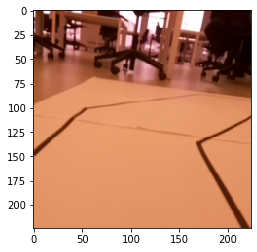

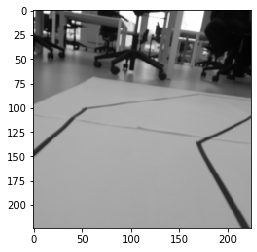

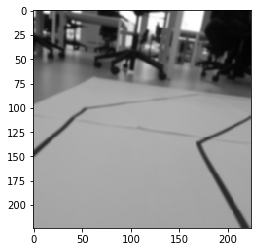

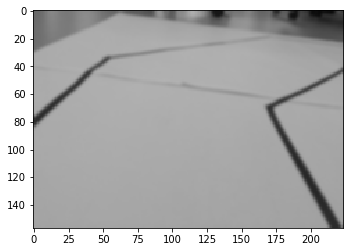

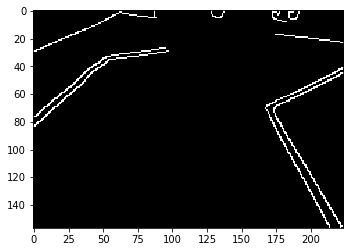

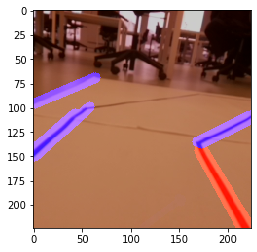

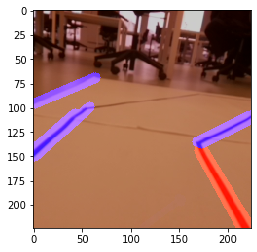

In [14]:
show_image(get_lines(X_val_bgr[200], show=True)[1])

In [15]:
img_set = [X_val_bgr[i] for i in range(0, 4000, 150)]

In [16]:
img_lines_set = [get_lines(img)[1] for img in img_set]

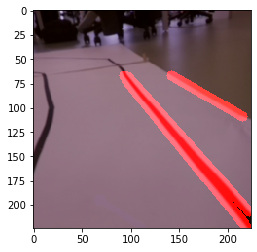

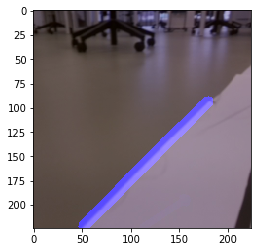

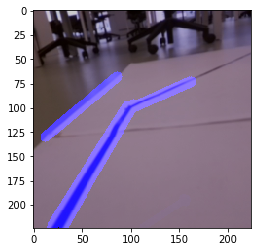

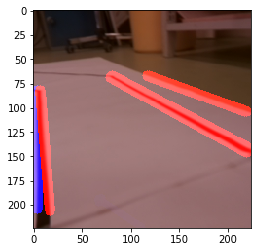

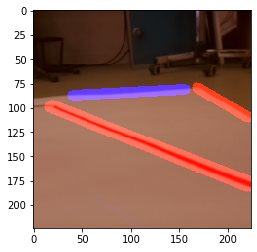

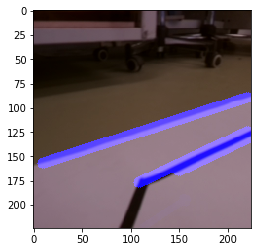

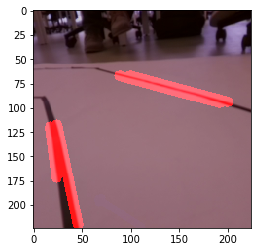

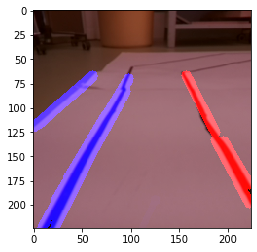

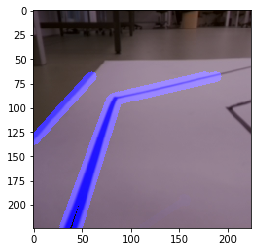

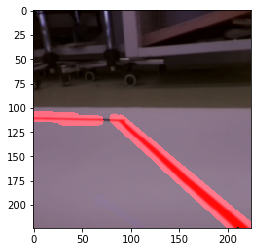

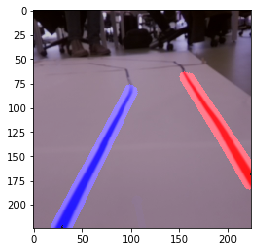

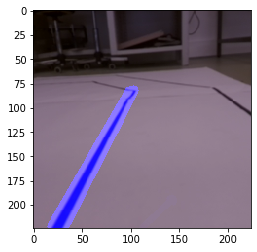

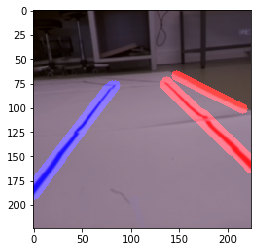

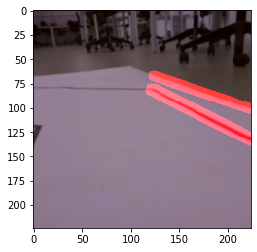

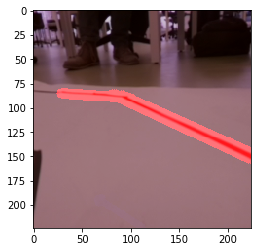

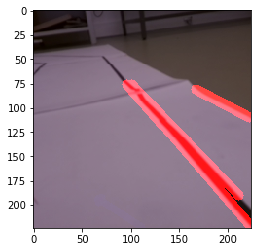

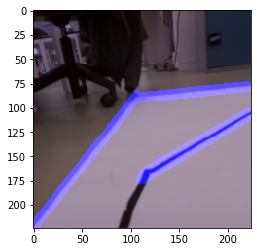

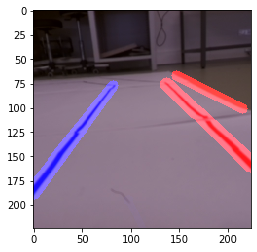

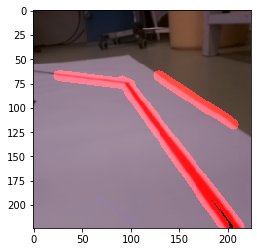

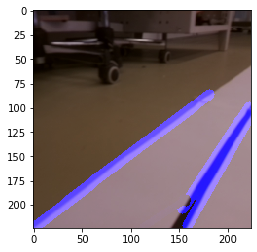

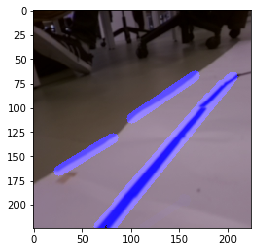

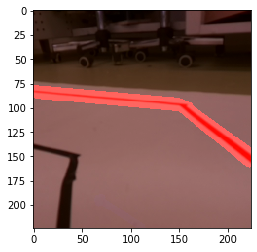

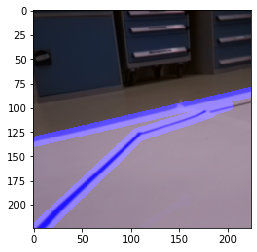

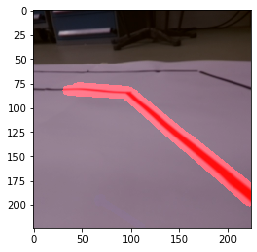

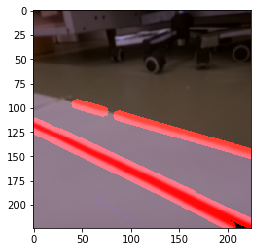

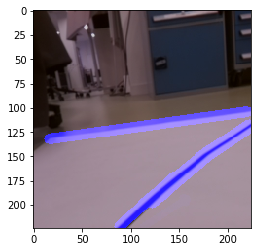

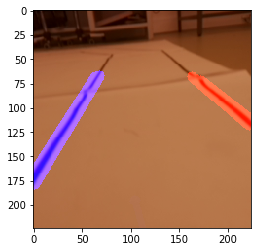

In [17]:
for img_lines in img_lines_set:
    show_image(img_lines)

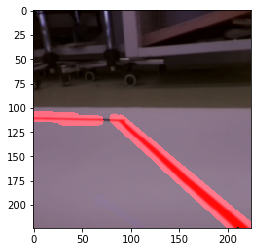

In [18]:
lines, img_lines = get_lines(X_val_bgr[1350])
show_image(img_lines)

In [19]:
def get_direction(lines):
    return lib.angle_from_lines(lines, False)

In [20]:
def stick_to_labels(get_direction):
    def f(lines):
        if get_direction(lines) < -0.75:
            return -1
        elif get_direction(lines) < -0.25:
            return -0.5
        elif get_direction(lines) < 0.25:
            return 0
        elif get_direction(lines) < 0.75:
            return 0.5
        return 1
    return f

In [21]:
get_direction(lines)

-1.0

In [22]:
class ClassicHoughlinesEstimator(lib.Estimator):
    def __init__(self, get_lines, get_direction):
        self.get_lines = get_lines
        self.get_direction = get_direction
    
    def predict_one(self, img):
        return self.get_direction(self.get_lines(img)[0])

In [23]:
ClassicHoughlinesEstimator(get_lines, get_direction).score(X_val, y_val)

(0.3347631593460113, 0.38974427638557124)

In [24]:
ClassicHoughlinesEstimator(get_lines, stick_to_labels(get_direction)).score(X_val, y_val)

(0.34701910551454623, 0.39489795918367343)

In [47]:
def get_direction_threshold(threshold):
    def get_direction(lines):  
        if lines is None:
            return 0
        
        angles, _ = lib.lines_angles(lines)
        left_angles = [a for a in angles if a < 0]
        right_angles = [a for a in angles if a > 0]
        
        all_left = (angles < 0).all()
        all_right = (angles > 0).all()
                    
        # get direction from difference
        if len(angles) == 0: return 0
        elif all_left or all_right: return lib.normalize_angle(np.mean(angles))

        
        l_mean = np.mean(left_angles)
        r_mean = np.mean(right_angles)
        
        # l_mean is negative
        diff = - l_mean - r_mean
        if abs(diff) < threshold:
            return 0
        
        # Majority to the left
        if diff > 0:
            return lib.normalize_angle(np.mean(left_angles))
        
        # Else majority to the right
        return lib.normalize_angle(np.mean(right_angles))
    
    return get_direction

In [48]:
get_direction_threshold(5)(lines)

-1.0

In [49]:
for threshold in [1, 3, 5, 7, 9, 11, 15, 17, 25]:
    print(ClassicHoughlinesEstimator(get_lines, get_direction_threshold(threshold)).score(X_val, y_val))

(0.6633456281162765, 0.583522186252168)
(0.6152392527869349, 0.5606229699194331)
(0.5887770714284993, 0.546661527951532)
(0.5595605410155005, 0.5326472083148627)
(0.5450089945094353, 0.5250279061015826)
(0.5330124310316388, 0.5183680266826238)
(0.5027814403375436, 0.49529052621631825)
(0.48114405171470126, 0.4758005503459597)
(0.4243010206544048, 0.4366632579751819)


In [51]:
class ZeroEstimator(lib.Estimator):
    def predict_one(self, img):
        return 0

In [52]:
print(ZeroEstimator().score(X_val, y_val))

(0.5003300043421623, 0.5913590968302215)


In [ ]:
class DumbEstimator(Estimator):
    def predict_one(self, img):
        return 2*random.random()-1

In [ ]:
print(DumbEstimator().score(X_val, y_val))

In [ ]:
def get_direction_mean(lines):
    if lines is None:
        return 0
    left = []
    right = []
    for line in lines:
        for rho, theta in line:
            # the higher the value, the more we should turn
            if theta > np.pi/2:
                left.append(np.pi - theta)
            else:
                right.append(theta)
    # get direction (keep intensity from main direction)
    if not left and not right:
        return 0
    elif not left:
        return np.mean(right)/(np.pi/2)
    elif not right:
        return -np.mean(left)/(np.pi/2)
    else:
        return 0

In [ ]:
ClassicHoughlinesEstimator(get_lines, get_direction_mean).score(X_val, y_val)

In [ ]:
ClassicHoughlinesEstimator(get_lines, stick_to_labels(get_direction_mean)).score(X_val, y_val)

In [ ]:
def get_direction_max(lines):
    if lines is None:
        return 0
    left = []
    right = []
    for line in lines:
        for rho, theta in line:
            # the higher the value, the more we should turn
            if theta > np.pi/2:
                left.append(np.pi - theta)
            else:
                right.append(theta)
    # get direction (keep intensity from main direction)
    if not left and not right:
        return 0
    elif not left:
        return np.max(right)/(np.pi/2)
    elif not right:
        return -np.max(left)/(np.pi/2)
    else:
        return 0

In [ ]:
ClassicHoughlinesEstimator(get_lines, get_direction_max).score(X_val, y_val)

In [ ]:
ClassicHoughlinesEstimator(get_lines, stick_to_labels(get_direction_max)).score(X_val, y_val)

In [ ]:
def get_direction_sin_max(lines):
    if lines is None:
        return 0
    left = []
    right = []
    for line in lines:
        for rho, theta in line:
            # the higher the value, the more we should turn
            if theta > np.pi/2:
                left.append(np.pi - theta)
            else:
                right.append(theta)
    # get direction (keep intensity from main direction)
    if not left and not right:
        return 0
    elif not left:
        return math.sin(np.max(right))
    elif not right:
        return math.sin(-np.max(left))
    else:
        return 0

In [ ]:
ClassicHoughlinesEstimator(get_lines, get_direction_sin_max).score(X_val, y_val)

In [ ]:
ClassicHoughlinesEstimator(get_lines, stick_to_labels(get_direction_sin_max)).score(X_val, y_val)

In [ ]:
def get_direction_sin_mean(lines):
    if lines is None:
        return 0
    left = []
    right = []
    for line in lines:
        for rho, theta in line:
            # the higher the value, the more we should turn
            if theta > np.pi/2:
                left.append(np.pi - theta)
            else:
                right.append(theta)
    # get direction (keep intensity from main direction)
    if not left and not right:
        return 0
    elif not left:
        return math.sin(np.mean(right))
    elif not right:
        return math.sin(-np.mean(left))
    else:
        return 0

In [ ]:
ClassicHoughlinesEstimator(get_lines, get_direction_sin_mean).score(X_val, y_val)

In [ ]:
ClassicHoughlinesEstimator(get_lines, stick_to_labels(get_direction_sin_mean)).score(X_val, y_val)

In [ ]:
import lib 
def preprocess_cluster(img, show=False):
    return lib.remove_clusters(lib.cluster_filter(img), 2000).astype(np.uint8)

def get_lines_cluster(img):
    return get_lines(img, preprocess=preprocess_cluster)

estimator = ClassicHoughlinesEstimator(get_lines_cluster, get_direction_max)

In [ ]:
s = time.time()
estimator.score(X_val[400:500], y_val[400:500])
print(time.time() - s)